<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part2_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.0


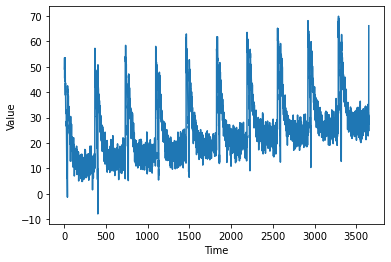

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(series, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

i = 0
for x, y in dataset:
  i += 1
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  if i == 1:
    break

x =  [[24.582458   19.8141     17.028278   22.470196   27.402098   17.103304
  21.779108   22.478508   18.93572    17.946981   19.936209   19.83779
  20.557642   17.970793   17.213585   20.29982    12.647415   21.018763
  18.512978   16.310848  ]
 [-7.867497   50.75872    42.026882   39.73629    41.459576   42.004948
  41.22559    41.02035    33.20054    38.53658    35.38432    32.722183
  36.83431    33.893654   32.748516   34.962265   39.18458    35.66821
  32.20552    36.683598  ]
 [32.748516   34.962265   39.18458    35.66821    32.20552    36.683598
  31.761732   32.762928   28.970518   28.013083   31.133984   30.472116
  24.295946   29.440903   34.637123   29.008507   25.707144   27.12171
  25.027847   26.299822  ]
 [38.32953    33.622574   32.6103     31.947649   32.078766   33.063114
  31.547438   32.10458    26.621574   28.619835   24.416117   20.2805
  18.039778   11.110561    9.938544    6.099659   12.934372    8.145386
   6.997644    5.8165345 ]
 [10.498429   15.435229   12

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [9]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [10]:
model.fit(dataset, epochs=100, verbose=0)

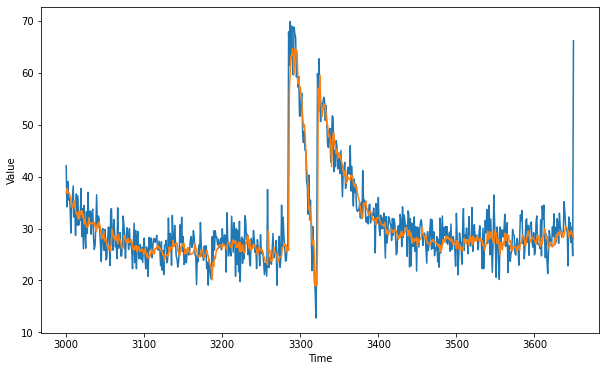

In [11]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.8030124